In [13]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/FakeNews.csv',index_col=0)
data.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,title,text,subject,date,class
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


In [ ]:
data.shape

(44919, 5)

In [ ]:
data = data.drop(["title", "subject","date"], axis = 1)

In [ ]:
data.isnull().sum()

,0
text,0
class,0


In [ ]:
# Shuffling
data = data.sample(frac=1)
data.reset_index(inplace=True)
data.drop(["index"], axis=1, inplace=True)

<Axes: xlabel='class', ylabel='count'>

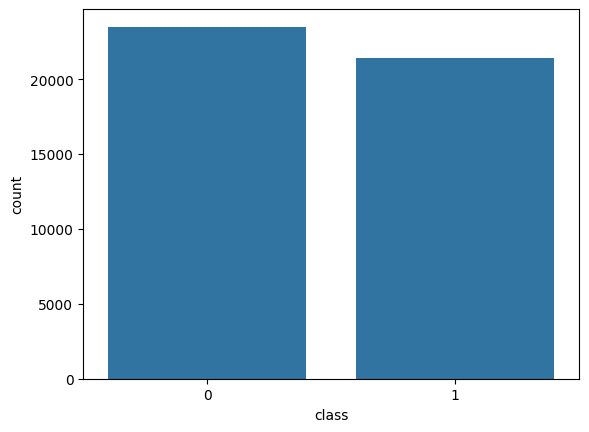

In [ ]:
sns.countplot(data=data,
              x='class',
              order=data['class'].value_counts().index)

In [ ]:
from tqdm import tqdm
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def preprocess_text(text_data):
    preprocessed_text = []

    for sentence in tqdm(text_data):
        sentence = re.sub(r'[^\w\s]', '', sentence)
        preprocessed_text.append(' '.join(token.lower()
                                  for token in str(sentence).split()
                                  if token not in stopwords.words('english')))

    return preprocessed_text

In [ ]:
preprocessed_review = preprocess_text(data['text'].values)
data['text'] = preprocessed_review

100%|██████████| 44919/44919 [33:40<00:00, 22.23it/s]


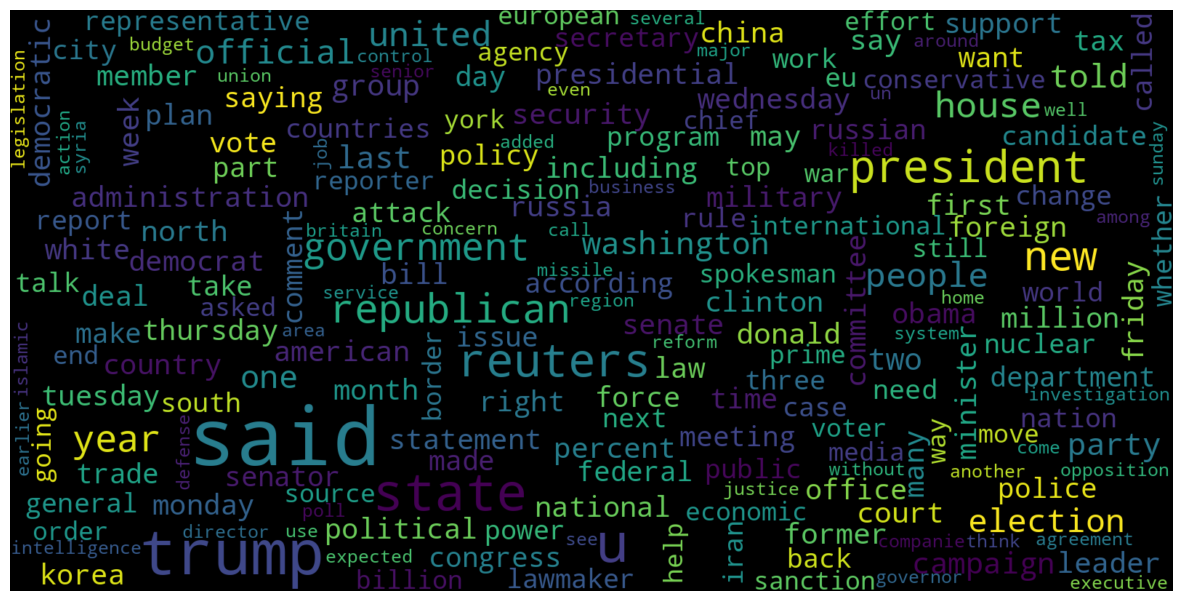

In [ ]:
# Real
consolidated = ' '.join(
    word for word in data['text'][data['class'] == 1].astype(str))
wordCloud = WordCloud(width=1600,
                      height=800,
                      random_state=21,
                      max_font_size=110,
                      collocations=False)
plt.figure(figsize=(15, 10))
plt.imshow(wordCloud.generate(consolidated), interpolation='bilinear')
plt.axis('off')
plt.show()


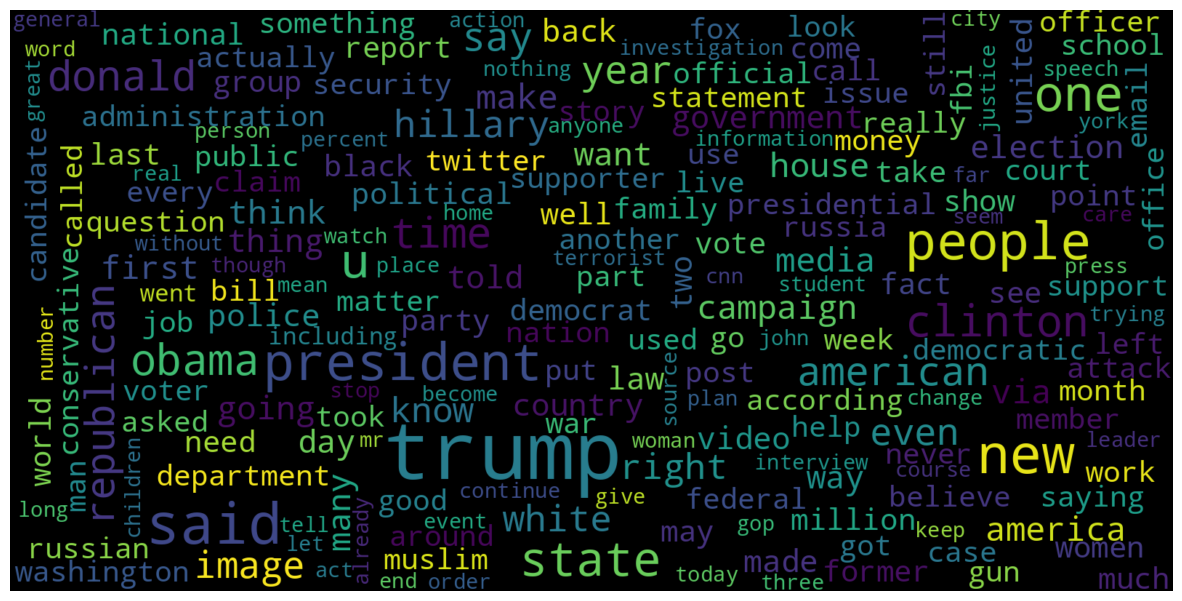

In [ ]:
# Fake
consolidated = ' '.join(
    word for word in data['text'][data['class'] == 0].astype(str))
wordCloud = WordCloud(width=1600,
                      height=800,
                      random_state=21,
                      max_font_size=110,
                      collocations=False)
plt.figure(figsize=(15, 10))
plt.imshow(wordCloud.generate(consolidated), interpolation='bilinear')
plt.axis('off')
plt.show()


<Axes: title={'center': 'Bar Chart of Top Words Frequency'}, xlabel='Top Words', ylabel='Count'>

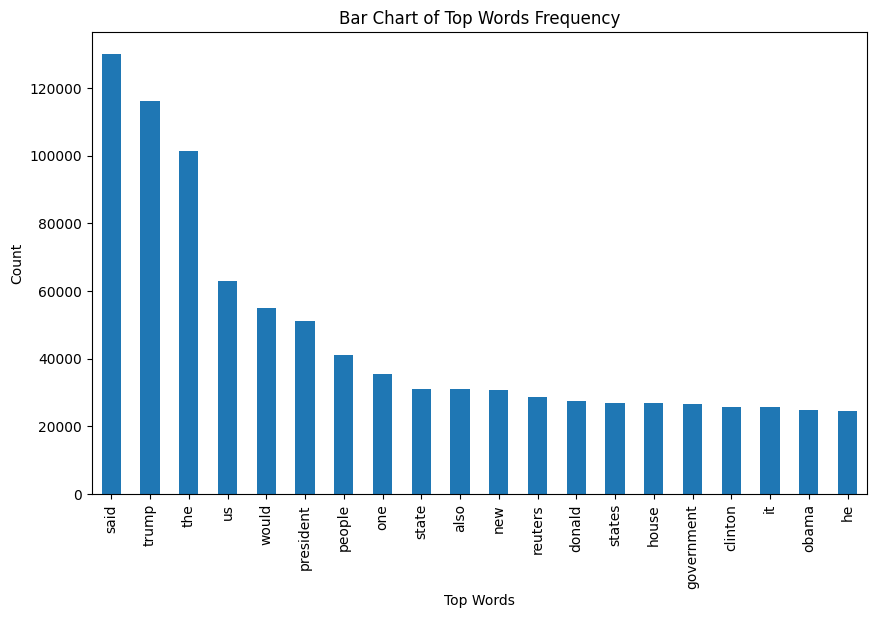

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer


def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx])
                  for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1],
                        reverse=True)
    return words_freq[:n]


common_words = get_top_n_words(data['text'], 20)
df1 = pd.DataFrame(common_words, columns=['Review', 'count'])

df1.groupby('Review').sum()['count'].sort_values(ascending=False).plot(
    kind='bar',
    figsize=(10, 6),
    xlabel="Top Words",
    ylabel="Count",
    title="Bar Chart of Top Words Frequency"
)


In [20]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

x_train, x_test, y_train, y_test = train_test_split(data['text'],
                                                    data['class'],
                                                    test_size=0.25)


In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorization = TfidfVectorizer()
x_train = vectorization.fit_transform(x_train)
x_test = vectorization.transform(x_test)

In [22]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(x_train, y_train)

# testing the model
print(accuracy_score(y_train, model.predict(x_train)))
print(accuracy_score(y_test, model.predict(x_test)))

0.9907981833833002
0.9870881567230633


In [24]:
from sklearn.tree import DecisionTreeClassifier
# from sklearn.metrics import accuracy_score, classification_report

model = DecisionTreeClassifier()
model.fit(x_train, y_train)

# testing the model
print(accuracy_score(y_train, model.predict(x_train)))
print(accuracy_score(y_test, model.predict(x_test)))



0.9999703167205913
0.9958147818343722


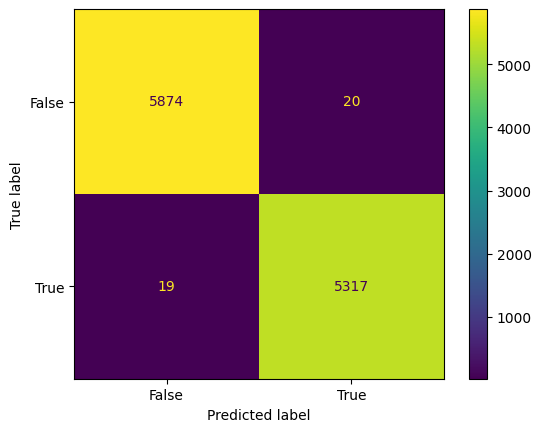

In [ ]:
# Confusion matrix of Results from Decision Tree classification
from sklearn import metrics
cm = metrics.confusion_matrix(y_test, model.predict(x_test))

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                                            display_labels=[False, True])

cm_display.plot()
plt.show()

In [16]:
# Import necessary libraries
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments, TrainerCallback
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
import numpy as np

# Load the dataset
# data = pd.read_csv('/content/drive/MyDrive/ml-datasets/News.csv')

# Use the 'text' column as input and 'class' column as labels
texts = data['text'].tolist()
labels = data['class'].tolist()

# Split the dataset into training and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=42
)

# Load the tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Tokenize the data
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=512)

# Convert the tokenized data into PyTorch Dataset format
class NewsDataset(torch.utils.data.Dataset):
    def _init_(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def _len_(self):
        return len(self.labels)

    def _getitem_(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

train_dataset = NewsDataset(train_encodings, train_labels)
val_dataset = NewsDataset(val_encodings, val_labels)

# Load the pre-trained DistilBERT model for sequence classification
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

# Define training arguments with memory-efficient settings
training_args = TrainingArguments(
    output_dir='./results',          # Output directory
    evaluation_strategy="epoch",    # Evaluate each epoch
    save_strategy="epoch",          # Save checkpoints each epoch
    learning_rate=5e-5,             # Learning rate
    per_device_train_batch_size=8,  # Reduced batch size for training
    per_device_eval_batch_size=16,  # Reduced batch size for evaluation
    num_train_epochs=3,             # Total number of training epochs
    weight_decay=0.01,              # Strength of weight decay
    logging_dir='./logs',           # Directory for storing logs
    logging_steps=10,
    save_total_limit=2,             # Limit the total checkpoints
    load_best_model_at_end=True,    # Load the best model at the end
    fp16=True,                      # Enable mixed precision
    gradient_accumulation_steps=1,  # Accumulate gradients for larger effective batch size
)

# Define the compute_metrics function with manual accuracy calculation
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, predictions)
    return {"accuracy": acc}

# Define a custom callback to save the model periodically
class SaveCheckpointCallback(TrainerCallback):
    def _init_(self, save_steps, output_dir):
        self.save_steps = save_steps
        self.output_dir = output_dir

    def on_step_end(self, args, state, control, **kwargs):
        # Save the model periodically
        if state.global_step % self.save_steps == 0:
            output_dir = f"{self.output_dir}/checkpoint-{state.global_step}"
            kwargs["model"].save_pretrained(output_dir)
            kwargs["tokenizer"].save_pretrained(output_dir)
            print(f"Checkpoint saved at step {state.global_step} to {output_dir}")

# Add the callback to Trainer
checkpoint_callback = SaveCheckpointCallback(save_steps=500, output_dir="./results")

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[checkpoint_callback],  # Register the callback
)

# Train the model with checkpoint saving
try:
    trainer.train(resume_from_checkpoint=True)  # Resume if checkpoint exists
except Exception as e:
    print("Error during training:", e)

# Evaluate the model
results = trainer.evaluate()
print("Evaluation Results:", results)

# Save the trained model and tokenizer
model.save_pretrained("./fake_news_model")
tokenizer.save_pretrained("./fake_news_model")

# Load the model for inference
from transformers import pipeline

classifier = pipeline("text-classification", model="./fake_news_model", tokenizer="./fake_news_model")

# Predict on a new sample
sample_text = "This is a sample news article text."
prediction = classifier(sample_text)
print("Prediction:", prediction)

TypeError: NewsDataset() takes no arguments